# ATML - Melanoma detection

The complete solution can be found on github (https://github.com/kennyster92/FS2019_ATML_Group2A).

## Melanoma classification on 

Goal: Implement a deep learning algorithm to classify pictures of a melanoma as benign or malignant, based on the ISIC database (https://www.isic-archive.com/#!/topWithHeader/onlyHeaderTop/gallery).

## Approach description

We use the ResNet50 network architecture. We train the network using the cross-entropy loss for classification into benign and malignant, with a fixed learning rate, using the Adam optimizer. We did a heavy data augmentation for increasing the amount of malignant cases since they were not enough. Moreover, we included a pretrained model on the ImageNet dataset to increase even more the accuracy of the model.

The training and Dataset classes can be found in ***'./bin/train/Training.py'*** and ***'./bin/train/MelanomaDataset.py'***

To estabilish which model was better than the others we looked at the accuracy value on the validation dataset.

## Results

| Setting | Train accuracy [\%] | Validation accuracy [\%] | Test accuracy [\%] |
| --- | --- | --- | --- |
| 1st experiment | 85.1779 | 70.1000 | 71.1000 |
| 2nd experiment | 90.0833 | 72.6000 | 72.3000 |
| 3rd experiment | 100.0000 | 88.7000 | 88.5000 |

***1st experiment:*** 
model: AlexNet, optimizer: SGD, loss: CrossEntropy, epochs: 25, batch size: 32, learning rate: 0.001, pretraining: false

***2nd experiment:***
model: ResNet50, optimizer: SGD, loss: CrossEntropy, epochs: 20, batch size: 32, learning rate: 0.001, pretraining: false

***3rd experiment: (best result)***
model: ResNet50, optimizer: Adam, loss: CrossEntropy, epochs: 27, batch size: 32, learning rate: 0.001, pretraining: true

The test accuracy is directly calculated after the training with 1000 images (500 benigns and 500 malignants)

### Learning curves

![title](Plot_loss_figure_exp_1003.png)
![title](Plot_accuracy_figure_exp_1003.png)

We can see that after the epoch 25 we start having an overfitting. To avoid this issue we can implement an early stopping or simply decrase the number of epochs to 25. This in our opinion is due to the fact that the amount of malignant cases is quite low and to increase the samples we make a strong use of data augmentation. Doing so the model is learning 'always' on the same malignant cases, specializing a lot on few features.


### Example of use

This example of use assume that all the images are ready and the model is already trained. 
If it is not the case, some scripts have to be executed before. 

The first is the script that downloads the images from the gallery mentioned above. To do it run the file ***'./data_downloader/data_downloader.py'***. 

The next one is responsible to do the data augmentation. To do it, execute the file ***'./data_enhancer/data_enhancer.py'***. 

The last script to run is the one that pack all the files into a file with extension '.npy'. This has to be done for the labels and the images separately executing respectively the files ***'./data_packer/data_packer.py'*** and ***'./data_packer/data_packer2.py'***.

Finally, to run the learning process, run the ***'main.py'*** file giving as input the path for the config file and the data set.

Example: ***'main.py --config_file /home/user/ATML/bin/config/config1003.json --data_path /home/user/ATML/data/'***

The config file must follow a strict structure. An example of this file is given below

In [77]:
{
    "config": {
        "result_dir": "./results/",
        "model_dir": "./models/",
        "model": "resnet50",
        "optimizer": "sgd",
        "loss_function": "CrossEntropy",
        "scheduler": "none",
        "experiment_name": "100",
        "epochs": 25,
        "batch_size": 16,
        "learning_rate": 0.001,
        "pretrained": "true"
    },
    "meta": {
        "type": "",
        "version": 1
    }
}

{'config': {'result_dir': './results/',
  'model_dir': './models/',
  'model': 'resnet50',
  'optimizer': 'sgd',
  'loss_function': 'CrossEntropy',
  'scheduler': 'none',
  'experiment_name': '100',
  'epochs': 25,
  'batch_size': 16,
  'learning_rate': 0.001,
  'pretrained': 'true'},
 'meta': {'type': '', 'version': 1}}

In [78]:
# load the libraries
import torch
import tqdm

# load the model
from cnn.Resnet50 import resnet50

model = resnet50(pretrained = False)
model.load_state_dict(torch.load('./model_001_24.pth', map_location='cpu'))
model.eval();

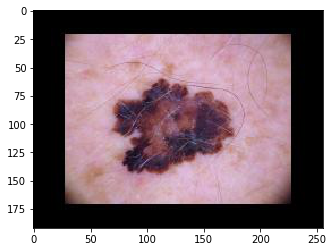

In [79]:
# Load sample image
import numpy as np
from PIL import Image

image = Image.open('1_ISIC_0030824_downsampled.jpg')

image = np.array(image)

# Show image
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(image)

In [80]:
# Run prediction
label2name = {0:'Benign', 1:'Malignant'}
with torch.no_grad():
    out = model(torch.Tensor(image).view(1,3,256,192))
    out = torch.softmax(out, -1)
    
ind = out[0].cpu().numpy().argmax()
print('Prediction: {}, score: {:.4f}'.format(label2name[ind], out[0][ind]))

Prediction: Benign, score: 1.0000


## Sample test set errors

In [81]:
# Create the test data set 
from torchvision.transforms import ToTensor, Compose
from bin.train import MelanomaDataset as data

images = np.load('./TEST_200IMG.npy')
labels = np.load('./TEST_200TAG.npy')

Transforms = Compose([ToTensor()])    
test_dataset = data.MelanomaDataset(images, labels, transform=Transforms)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [82]:
# Run prediction
predictions = []
prediction_scores = []
labels = []
loop = tqdm.tqdm(test_loader)
for images, target in test_loader:
    labels.extend(target)
    images = images.float()
    images = images.to('cpu')
    with torch.no_grad():
        output = model(images)
        output = torch.softmax(output, -1)
    output = output.cpu().numpy()
    preds = output.argmax(-1)
    predictions.extend(preds)
    prediction_scores.extend(output[np.arange(output.shape[0]), preds])
error_indices = np.where(np.array(labels) != np.array(predictions))[0]

TP = 0
FP = 0
TN = 0
FN = 0

for i in range(len(np.array(labels))):
    if np.array(labels)[i] == 0:
        if np.array(predictions)[i] == 0:
            TN = TN + 1
        else:
            FP = FP + 1
    else:
        if np.array(predictions)[i] == 1:
            TP = TP + 1
        else:
            FN = FN + 1
               
nbOfOK = len(np.array(labels))-len(error_indices)

print("Test in a small part of dataset (100 benigns and 100 malignants):")
print("Number total of errors: ", len(error_indices))
print("Accuracy: ", 100*nbOfOK/len(np.array(labels)), "%")

print("Number of false positives: ", FP)
if TP != 0:
    print("Sensitivity: ", TP/(TP+FN))

print("Number of false negatives: ", FN)
if TN != 0:
    print("Specificity: ", TN/(TN+FP))

print('Indexes with errors: ', error_indices)






























  0%|          | 0/7 [00:00<?, ?it/s]

Test in a small part of dataset (100 benigns and 100 malignants):
Number total of errors:  16
Accuracy:  92.0 %
Number of false positives:  13
Sensitivity:  0.97
Number of false negatives:  3
Specificity:  0.87
Indexes with errors:  [  1   4  20  30  41  42  55  57  63  67  76  83  96 111 124 177]


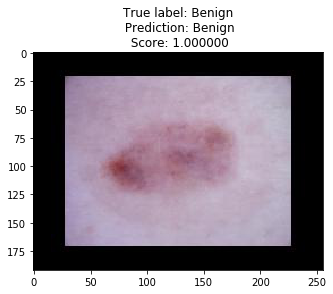

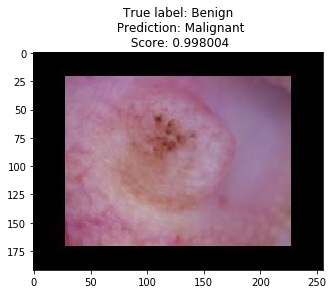

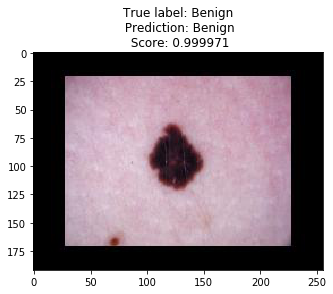

In [83]:
id = 0

for images, labels in loop:
    image2show = images[id]
    
    plt.title('True label: {}\n Prediction: {}\n Score: {:.6f}'.format(label2name[labels[id].item()],
                                                                    label2name[predictions[id].item()],
                                                                    prediction_scores[id]))
    plt.imshow(image2show.numpy().transpose(1, 2, 0))   
    plt.show()   
    id += 1
    image2show = images[id]
    plt.title('True label: {}\n Prediction: {}\n Score: {:.6f}'.format(label2name[labels[id].item()],
                                                                    label2name[predictions[id].item()],
                                                                    prediction_scores[id]))
    plt.imshow(image2show.numpy().transpose(1, 2, 0))    
    plt.show()   
    id += 1
    image2show = images[id]
    plt.title('True label: {}\n Prediction: {}\n Score: {:.6f}'.format(label2name[labels[id].item()],
                                                                    label2name[predictions[id].item()],
                                                                    prediction_scores[id]))
    plt.imshow(image2show.numpy().transpose(1, 2, 0))    
    plt.show() 
    
    break